# Today's at the moment stock data analysis

For my project I wanted to look at today's at the moment stock data and find out the top 5 largest stock by volume at the particular time and using yfinance get the information about those stocks and thru data visualization see how that stock is performing for the past year. I wanted to see when was the highest high, lowest low, when was the closing price of the data high n low as well as the opening price of the data. 


I am using yfinance which is built in on yahoo finance API for my analysis and for my visualisation I am using plotly as I am plotting interactive data.

In [223]:
import yfinance as yf
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import plotly.express as px

# to print current time and a day of the week and formatted
date = pd.Timestamp(datetime.datetime.today())
today = f"{date.day_name()} {date.strftime('%m-%d-%y %H:%M:%S')} "
today
#print(f"Today is {today.day_name()} {today.strftime('%m-%d-%y %H:%M:%S')} ")



'Monday 03-20-23 00:01:43 '

In [224]:
def convert_scale(value):
    if value.endswith('M'):
        return float(value[:-1]) * 10**6
    elif value.endswith('B'):
        return float(value[:-1]) * 10**9
    elif value.endswith('T'):
        return float(value[:-1]) * 10**12
    else:
        return float(value)


In [225]:
# unit test

'''def test_convert_scale_string():
    scale = convert_scale('test')
    print(scale)
    assert scale == 0
    '''
def test_convert_scale_negative():
    scale = convert_scale('-5')
    print(scale)
    assert scale == -5.0

'''def test_convert_scale_M():
    scale = convert_scale('K')
    print(scale)
    assert scale == 0'''

def test_convert_scale_M():
    scale = convert_scale('5M')
    print(scale)
    assert scale == 5000000

'''def test_convert_scale_B():
    scale = convert_scale(f)
    print(scale)
    assert scale == 0'''

def test_convert_scale_B():
    scale = convert_scale('2B')
    print(scale)
    assert scale == 2000000000


In [226]:
#test_convert_scale_string()
test_convert_scale_negative()
test_convert_scale_M()
test_convert_scale_B()



-5.0
5000000.0
2000000000.0


Region: United States, Market Cap (Intraday): Mid Cap and Large Cap and Mega Cap, Volume:greater than 5000000

## Feature 1: Loading Data
As per the requirement, 2 data sets to be loaded in. I decided to use pandas, read_html function which reads HTML tables into a list of DataFrame objects. I am reading in the tables from https://finance.yahoo.com/. From there, I am webscraping most-active, gainers and losers tables. 

In [227]:
# reading in from a website and getting only the 1st page
most_active = pd.read_html('https://finance.yahoo.com/most-active')[0]
print(most_active.shape) #shows the shape of table
most_active.head() #print first 5 rows
#most_active.loc[most_active.Name.str.contains('(?i)CORP', regex=True)]


(25, 10)


,Symbol,Name,Price (Intraday),Change,% Change,Volume,Avg Vol (3 month),Market Cap,PE Ratio (TTM),52 Week Range
0,LUMN,"Lumen Technologies, Inc.",2.48,-0.01,-0.40%,316.011M,35.381M,2.493B,NaN,NaN
1,F,Ford Motor Company,11.30,-0.52,-4.40%,249.885M,67.838M,47.117B,NaN,NaN
2,FRC,First Republic Bank,23.03,-11.24,-32.80%,149.194M,13.974M,6.382B,4.16,NaN
3,CS,Credit Suisse Group AG,2.01,-0.15,-6.94%,138.426M,34.636M,8.556B,NaN,NaN
4,TSLA,"Tesla, Inc.",180.13,-4.00,-2.17%,133.197M,183.85M,569.949B,50.46,NaN


In [228]:
# reading in 2nd table
gainers = pd.read_html('https://finance.yahoo.com/gainers')[0]
print(gainers.shape)
gainers.head()


(25, 10)


,Symbol,Name,Price (Intraday),Change,% Change,Volume,Avg Vol (3 month),Market Cap,PE Ratio (TTM),52 Week Range
0,BAIDF,"Baidu, Inc.",17.56,1.96,+12.60%,45110,21317,44.059B,47.46,NaN
1,KDKWF,Kadokawa Corporation,20.07,2.07,+11.50%,20006,333,2.795B,18.76,NaN
2,MSTR,MicroStrategy Incorporated,267.66,26.58,+11.03%,2.022M,657520,2.784B,NaN,NaN
3,COIN,"Coinbase Global, Inc.",74.98,7.20,+10.62%,31.006M,18.878M,19.637B,7.67,NaN
4,GSAT,"Globalstar, Inc.",1.14,0.10,+9.62%,9.49M,3.801M,2.065B,NaN,NaN


In [229]:
# reading in 3rd table
losers = pd.read_html('https://finance.yahoo.com/losers')[0]
print(losers.shape)
losers.head()


(25, 10)


,Symbol,Name,Price (Intraday),Change,% Change,Volume,Avg Vol (3 month),Market Cap,PE Ratio (TTM),52 Week Range
0,FRC-PI,First Republic Bank,10.15,-5.47,-35.02%,793074,97755,6.399B,1.29,NaN
1,FRC-PH,First Republic Bank,9.36,-4.65,-33.19%,654472,82890,6.029B,1.19,NaN
2,FRC,First Republic Bank,23.03,-11.24,-32.80%,149.194M,13.974M,6.382B,4.16,NaN
3,GOCO,"GoHealth, Inc.",13.22,-4.28,-24.46%,143941,52322,2.841B,NaN,NaN
4,SRPT,"Sarepta Therapeutics, Inc.",122.69,-26.98,-18.03%,7.413M,1.344M,10.795B,NaN,NaN


## Feature 2: Clean and operate on the data while combining them.
Next requirement for the project is to combine the datasets to create new dataset and do analysis on it. By looking at the tables, I want to join, columns on all of them are same, thus pandas concat function works well for it. Concat function stacks the dataset on top of each other, thus to have a continuos index 'ignore_index=True' param is used. 
To clean the dataset, I created a custom function that converts 'M','B' &'T' into its corresponding 10^n values. Data also consists of NaN values, thus I dropped one column and replaced NaN values to 0, on another column as well as replaced % to ''.

In [230]:
# joining 3 datasets into 1 dataframe.
stocks_df = pd.concat([most_active, gainers, losers], ignore_index=True)
print(stocks_df.shape) # shows shape of new dataframe
print(f'Datatype before the change \n {stocks_df.info()}')
stocks_df.head() # prints top 5 rows



(75, 10)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75 entries, 0 to 74
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Symbol             75 non-null     object 
 1   Name               75 non-null     object 
 2   Price (Intraday)   75 non-null     float64
 3   Change             75 non-null     float64
 4   % Change           75 non-null     object 
 5   Volume             75 non-null     object 
 6   Avg Vol (3 month)  75 non-null     object 
 7   Market Cap         75 non-null     object 
 8   PE Ratio (TTM)     55 non-null     float64
 9   52 Week Range      0 non-null      float64
dtypes: float64(4), object(6)
memory usage: 6.0+ KB
Datatype before the change 
 None


,Symbol,Name,Price (Intraday),Change,% Change,Volume,Avg Vol (3 month),Market Cap,PE Ratio (TTM),52 Week Range
0,LUMN,"Lumen Technologies, Inc.",2.48,-0.01,-0.40%,316.011M,35.381M,2.493B,NaN,NaN
1,F,Ford Motor Company,11.30,-0.52,-4.40%,249.885M,67.838M,47.117B,NaN,NaN
2,FRC,First Republic Bank,23.03,-11.24,-32.80%,149.194M,13.974M,6.382B,4.16,NaN
3,CS,Credit Suisse Group AG,2.01,-0.15,-6.94%,138.426M,34.636M,8.556B,NaN,NaN
4,TSLA,"Tesla, Inc.",180.13,-4.00,-2.17%,133.197M,183.85M,569.949B,50.46,NaN


Cleaning the dataframe:
Analyzing the data, I dropped '52 Week Range' column which consists of NaN values, fill in 0's where there was NaN values in 'PE Ratio (TTM)' column. Next up is converting the scale as well as changing the datatypes from object to float64 for 'Volume', 'Avg Vol (3 month)', 'Market Cap' columns. Regular expressions are handy when searching and cleaning text-based columns in Pandas. Finally, I replaced % to ' ' with a regex=True param and changed the datatype using pandas to_numeric function.

In [231]:
stocks_df['PE Ratio (TTM)'] = stocks_df['PE Ratio (TTM)'].fillna(0) # fill in 0 where NaN
stocks_df.dropna(axis=1, thresh=9, inplace=True) # drop a column

# using .apply function to convert the scale n datatypes
stocks_df['Volume'] = stocks_df['Volume'].apply(convert_scale) 
stocks_df['Avg Vol (3 month)'] = stocks_df['Avg Vol (3 month)'].apply(convert_scale)
stocks_df['Market Cap'] = stocks_df['Market Cap'].apply(convert_scale)

# replacing %:'' and changing the dtype of column
stocks_df['% Change'] = pd.to_numeric(stocks_df['% Change'].replace({'%' : ''}, regex=True))

print(f'Datatypes after the change: {stocks_df.info()}') # shows all the columns, non null count and dtypes
stocks_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75 entries, 0 to 74
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Symbol             75 non-null     object 
 1   Name               75 non-null     object 
 2   Price (Intraday)   75 non-null     float64
 3   Change             75 non-null     float64
 4   % Change           75 non-null     float64
 5   Volume             75 non-null     float64
 6   Avg Vol (3 month)  75 non-null     float64
 7   Market Cap         75 non-null     float64
 8   PE Ratio (TTM)     75 non-null     float64
dtypes: float64(7), object(2)
memory usage: 5.4+ KB
Datatypes after the change: None


,Symbol,Name,Price (Intraday),Change,% Change,Volume,Avg Vol (3 month),Market Cap,PE Ratio (TTM)
0,LUMN,"Lumen Technologies, Inc.",2.48,-0.01,-0.40,316011000.0,35381000.0,2.493000e+09,0.00
1,F,Ford Motor Company,11.30,-0.52,-4.40,249885000.0,67838000.0,4.711700e+10,0.00
2,FRC,First Republic Bank,23.03,-11.24,-32.80,149194000.0,13974000.0,6.382000e+09,4.16
3,CS,Credit Suisse Group AG,2.01,-0.15,-6.94,138426000.0,34636000.0,8.556000e+09,0.00
4,TSLA,"Tesla, Inc.",180.13,-4.00,-2.17,133197000.0,183850000.0,5.699490e+11,50.46


The pandas concat function stacks data sets on top of each other. Since, I am getting most_active, gainers and losers stock, most_active stocks could also be a gainer or a loser. Thus, I wanted to see if there is any duplicate rows. I used pandas duplicated() function to find such rows.

In [232]:
# find if there are any duplicated rows
duplicate = stocks_df[stocks_df.duplicated()]
duplicate

,Symbol,Name,Price (Intraday),Change,% Change,Volume,Avg Vol (3 month),Market Cap,PE Ratio (TTM)
52,FRC,First Republic Bank,23.03,-11.24,-32.80,149194000.0,13974000.0,6.382000e+09,4.16
64,USB,U.S. Bancorp,32.95,-3.41,-9.38,56443000.0,10640000.0,5.569600e+10,9.87


In [233]:
# if there is any duplicates drop_duplicates function will delete the rows, 
# keep='first' param keeps the first occurence and drops anything else. 
stocks_df.drop_duplicates(keep='first', inplace=True, ignore_index=True) # inplace= True would replace the original df 
print(stocks_df.shape) # prints updated shape of df
pd.set_option('display.max_rows', None) # displays all the rows
stocks_df # dispalys all the rows in a df


(73, 9)


,Symbol,Name,Price (Intraday),Change,% Change,Volume,Avg Vol (3 month),Market Cap,PE Ratio (TTM)
0,LUMN,"Lumen Technologies, Inc.",2.4800,-0.0100,-0.40,316011000.0,35381000.0,2.493000e+09,0.00
1,F,Ford Motor Company,11.3000,-0.5200,-4.40,249885000.0,67838000.0,4.711700e+10,0.00
2,FRC,First Republic Bank,23.0300,-11.2400,-32.80,149194000.0,13974000.0,6.382000e+09,4.16
3,CS,Credit Suisse Group AG,2.0100,-0.1500,-6.94,138426000.0,34636000.0,8.556000e+09,0.00
4,TSLA,"Tesla, Inc.",180.1300,-4.0000,-2.17,133197000.0,183850000.0,5.699490e+11,50.46
5,BAC,Bank of America Corporation,27.8200,-1.1500,-3.97,130666000.0,48757000.0,2.225400e+11,9.09
6,AAPL,Apple Inc.,155.0000,-0.8500,-0.55,98945000.0,70977000.0,2.465000e+12,25.96
7,AMD,"Advanced Micro Devices, Inc.",97.8400,1.2400,1.28,94081000.0,58932000.0,1.576580e+11,104.09
8,AMZN,"Amazon.com, Inc.",98.9500,-1.0900,-1.09,87300000.0,70003000.0,1.025000e+12,0.00
9,NVDA,NVIDIA Corporation,257.2500,1.8400,0.72,84855000.0,49362000.0,6.410670e+11,109.47


Data Analysis:



       Price (Intraday)     Change   % Change        Volume  \
count         73.000000  73.000000  73.000000  7.300000e+01   
mean          51.375388  -0.950981  -2.774247  3.925226e+07   
std           67.669342   6.306163  10.218790  5.638280e+07   
min            0.488300 -26.980000 -35.020000  1.922900e+04   
25%           11.530000  -2.230000  -8.800000  4.552000e+06   
50%           20.640000  -0.320000  -1.410000  1.165900e+07   
75%           56.410000   1.090000   5.850000  5.745800e+07   
max          279.430000  26.580000  12.600000  3.160110e+08   

       Avg Vol (3 month)    Market Cap  PE Ratio (TTM)  
count       7.300000e+01  7.300000e+01       73.000000  
mean        1.589140e+07  1.605934e+11       20.149863  
std         2.726319e+07  4.443102e+11       33.271460  
min         3.330000e+02  2.065000e+09        0.000000  
25%         8.473420e+05  3.704000e+09        0.000000  
50%         3.969000e+06  7.574000e+09        8.350000  
75%         1.887800e+07  5.07410

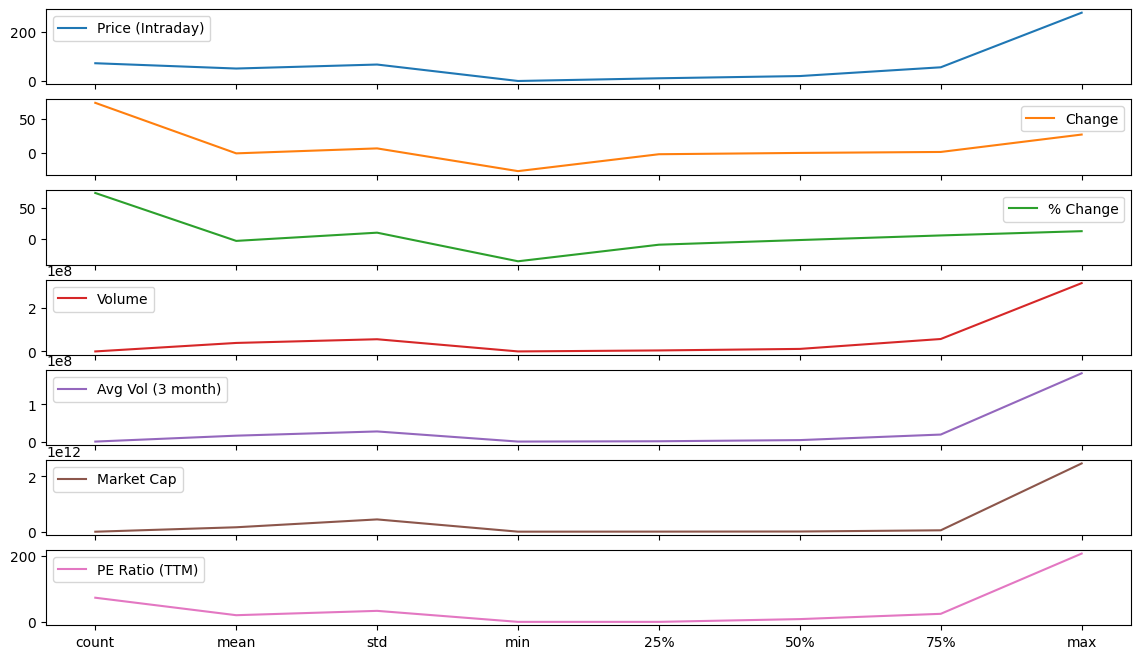

In [234]:

stocks_df.describe().plot(subplots=True, figsize=(14,8))
print(stocks_df.describe())

At the time of doing data analysis, Bank was a hot topic, thus I wanted to see how many bank stocks are in the list. By looking at data i noticed that some bank uses 'Banc' and some uses 'Bank', so to make it easier I searched for Ban. 

In [235]:
# find all rows that have 'Ban' in its name column?
stocks_df.loc[stocks_df.Name.str.contains('(?i)Ban', regex=True)]

,Symbol,Name,Price (Intraday),Change,% Change,Volume,Avg Vol (3 month),Market Cap,PE Ratio (TTM)
2,FRC,First Republic Bank,23.03,-11.24,-32.80,149194000.0,13974000.0,6.382000e+09,4.16
5,BAC,Bank of America Corporation,27.82,-1.15,-3.97,130666000.0,48757000.0,2.225400e+11,9.09
11,HBAN,Huntington Bancshares Incorporated,10.34,-0.64,-5.79,80447000.0,18188000.0,1.498900e+10,7.49
19,USB,U.S. Bancorp,32.95,-3.41,-9.38,56443000.0,10640000.0,5.569600e+10,9.87
22,NYCB,"New York Community Bancorp, Inc.",6.54,-0.32,-4.66,52709000.0,11801000.0,4.685000e+09,5.45
50,FRC-PI,First Republic Bank,10.15,-5.47,-35.02,793074.0,97755.0,6.399000e+09,1.29
51,FRC-PH,First Republic Bank,9.36,-4.65,-33.19,654472.0,82890.0,6.029000e+09,1.19
54,WAL,Western Alliance Bancorporation,31.32,-5.59,-15.14,24312000.0,4799000.0,4.046000e+09,3.81
59,NYCB-PA,"New York Community Bancorp, Inc.",15.65,-1.84,-10.52,477084.0,71772.0,2.676000e+09,12.84
63,ASB,Associated Banc-Corp,17.79,-1.75,-8.96,6689000.0,1721000.0,2.948000e+09,8.35


Get all the rows where volume is at least 20 million and the daily change is at least -5?

In [236]:
volume_change = stocks_df.query('Volume >= 20000000 and Change <= -5')[['Name', 'Change', 'Volume']]
volume_change

,Name,Change,Volume
2,First Republic Bank,-11.24,149194000.0
24,"Meta Platforms, Inc.",-9.32,50141000.0
54,Western Alliance Bancorporation,-5.59,24312000.0


Find stocks that dropped below 25% and print its symbol, name and % Change ?

In [237]:
stocks_below_25 = stocks_df.query('`% Change` < -25')[['Symbol', 'Name', '% Change']]
stocks_below_25

,Symbol,Name,% Change
2,FRC,First Republic Bank,-32.80
50,FRC-PI,First Republic Bank,-35.02
51,FRC-PH,First Republic Bank,-33.19


Any stocks that performed over 10% today and how many times they transacted today?

In [238]:
stocks_above_20 = stocks_df.query('`% Change` > 10')[['Symbol', 'Name', '% Change', 'Volume']]
stocks_above_20

,Symbol,Name,% Change,Volume
25,BAIDF,"Baidu, Inc.",12.60,45110.0
26,KDKWF,Kadokawa Corporation,11.50,20006.0
27,MSTR,MicroStrategy Incorporated,11.03,2022000.0
28,COIN,"Coinbase Global, Inc.",10.62,31006000.0


In [239]:

Symbol_s = stocks_df.loc[(stocks_df['PE Ratio (TTM)']>=5) & (stocks_df['Change']<= 5) & (stocks_df['Symbol'].str.startswith('S')),['Symbol', 'Name']]
Symbol_s

,Symbol,Name
15,SCHW,The Charles Schwab Corporation
20,STWD,"Starwood Property Trust, Inc."
48,SSRM,SSR Mining Inc.
68,SNV,Synovus Financial Corp.
70,SPWR,SunPower Corporation


Is there any company that has Market Cap of One Trillion or more? print only name and market cap.

In order to filter a DataFrame column that has spaces with the query method, we wrap the column using backticks. While this may not look great, it does allow us to use any column in the method.


                     Name    Market Cap
6              Apple Inc.  2.465000e+12
8        Amazon.com, Inc.  1.025000e+12
12          Alphabet Inc.  1.306000e+12
14  Microsoft Corporation  2.080000e+12
16          Alphabet Inc.  1.306000e+12


<AxesSubplot: title={'center': 'Largest Company by Market Cap in U.S'}, xlabel='Stocks', ylabel='$ in Trillion'>

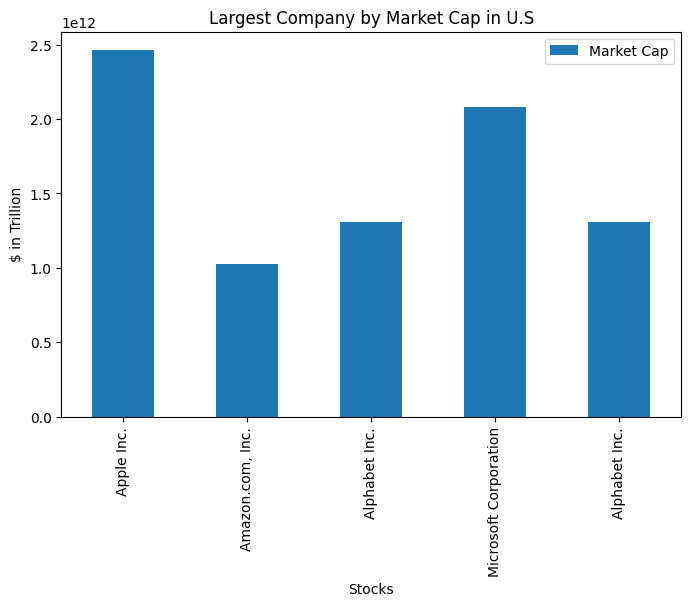

In [240]:
large_market_cap = stocks_df.query("`Market Cap` > 1000000000000")[['Name', 'Market Cap']]
print(large_market_cap)
large_market_cap.plot(kind='bar', figsize=(8,5), x='Name', y='Market Cap', xlabel='Stocks', ylabel='$ in Trillion', title=('Largest Company by Market Cap in U.S'))



## Feature 3: Visualize/Present your data.

Ultimately, I wanted to find out the top 5 companies by its Volume on a particular day and see how those stocks are performing for the past year. I am using yfinance library for this purpose. yfinance is a package designed to download historical stock data from Yahoo Finance. I am visualizing my data thru plotly library.

In [241]:
# Return the first 5 rows with the largest values in columns, in descending order
top_5_company = stocks_df.nlargest(5,['Volume'])
top_5_company


,Symbol,Name,Price (Intraday),Change,% Change,Volume,Avg Vol (3 month),Market Cap,PE Ratio (TTM)
0,LUMN,"Lumen Technologies, Inc.",2.48,-0.01,-0.40,316011000.0,35381000.0,2.493000e+09,0.00
1,F,Ford Motor Company,11.30,-0.52,-4.40,249885000.0,67838000.0,4.711700e+10,0.00
2,FRC,First Republic Bank,23.03,-11.24,-32.80,149194000.0,13974000.0,6.382000e+09,4.16
3,CS,Credit Suisse Group AG,2.01,-0.15,-6.94,138426000.0,34636000.0,8.556000e+09,0.00
4,TSLA,"Tesla, Inc.",180.13,-4.00,-2.17,133197000.0,183850000.0,5.699490e+11,50.46


In [242]:
# taking a column and chaging it to a list
top_5_volume = (top_5_company.Symbol).to_list()
top_5_volume

['LUMN', 'F', 'FRC', 'CS', 'TSLA']

With the yfinance's download method, multiple ticker symbols can be downloaded at the same time. For my project I am passing in the list generated each time I run the file. Since, my project is not rigid and the data changes according to how stock market performs. I am downloading a data for 1y period, with an interval od 1d period, the stock market is open, it ignores the timezone.
If you want to remove Adjust Close Price column then you can do so by setting auto_adjust= True
You can download dividends and splits of stock by setting actions ='inline'. For my project, I am not using the dividends and the stock splits.

In [243]:
ticker = yf.download(top_5_volume, period='1y',interval='1d', ignore_tz=True, progress=False, auto_adjust=True )
ticker.info() # displays information about the columns
pd.set_option('display.max_columns', None) # displays all the columns with a scroll bar
ticker.head()


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 251 entries, 2022-03-18 to 2023-03-17
Data columns (total 25 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   (Close, CS)     251 non-null    float64
 1   (Close, F)      251 non-null    float64
 2   (Close, FRC)    251 non-null    float64
 3   (Close, LUMN)   251 non-null    float64
 4   (Close, TSLA)   251 non-null    float64
 5   (High, CS)      251 non-null    float64
 6   (High, F)       251 non-null    float64
 7   (High, FRC)     251 non-null    float64
 8   (High, LUMN)    251 non-null    float64
 9   (High, TSLA)    251 non-null    float64
 10  (Low, CS)       251 non-null    float64
 11  (Low, F)        251 non-null    float64
 12  (Low, FRC)      251 non-null    float64
 13  (Low, LUMN)     251 non-null    float64
 14  (Low, TSLA)     251 non-null    float64
 15  (Open, CS)      251 non-null    float64
 16  (Open, F)       251 non-null    float64
 17  (Open, FRC)     

Close                                                    High  \
                  CS          F         FRC       LUMN        TSLA        CS   
Date                                                                           
2022-03-18  8.020674  15.438366  169.184082  10.612164  301.796661  8.030515   
2022-03-21  8.010833  15.090405  166.524933  10.487765  307.053345  8.060039   
2022-03-22  8.119087  15.648971  169.203934  10.487765  331.326660  8.217501   
2022-03-23  7.961626  15.273541  163.349823  10.401643  333.036682  8.069880   
2022-03-24  7.991150  15.410893  164.917511  10.420781  337.973328  8.010833   

                                                               Low             \
                    F         FRC       LUMN        TSLA        CS          F   
Date                                                                            
2022-03-18  15.474992  170.166389  10.669578  302.616669  7.784482  14.907272   
2022-03-21  15.667285  169.769509  10.765270  314.283325  7.932102  14.953054   
2022-03-22  15.850420  172.855325  10.612164  332.619995  8.099404  15.291856   
2022-03-23  15.612342  167.943809  10.660010  346.899994  7.941943  15.172816   
2022-03-24  15.548245  165.790658  10.478195  341.496674  7.882896  15.236914   

                                                   Open             \
                   FRC       LUMN        TSLA        CS          F   
Date                                                                 
2022-03-18  164.996896  10.315520  289.130005  7.784482  15.035466   
2022-03-21  164.510720  10.449489  302.363342  8.030515  15.447522   
2022-03-22  167.259183  10.344229  307.250000  8.109246  15.310168   
2022-03-23  162.258371  10.363366  325.466675  7.961626  15.401736   
2022-03-24  162.625461  10.325089  329.600006  7.922261  15.328482   

                                                 Volume                     \
                   FRC       LUMN        TSLA        CS         F      FRC   
Date                                                                         
2022-03-18  167.189718  10.401642  291.496674   9640200  89144000  1494300   
2022-03-21  169.045175  10.621733  304.993347  11540600  72583600   639700   
2022-03-22  168.132330  10.554749  310.000000   8832500  77647100  1557500   
2022-03-23  167.001200  10.506903  326.646667   7727800  63296800  1090600   
2022-03-24  163.052126  10.420781  336.576660   7632100  56314200   888800   

                                 
                LUMN       TSLA  
Date                             
2022-03-18  25454500  100414200  
2022-03-21   9575900   81981600  
2022-03-22   9577000  105868500  
2022-03-23   7396500  120676200  
2022-03-24   7265700   68920800

## Plotting Data


In [244]:
close = ticker.Close
close.info()
close.head()
print(close.describe())

fig = px.line(close, title=f"Closing Price for stocks with largest volume on {today} for past 1y") 
fig.show()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 251 entries, 2022-03-18 to 2023-03-17
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   CS      251 non-null    float64
 1   F       251 non-null    float64
 2   FRC     251 non-null    float64
 3   LUMN    251 non-null    float64
 4   TSLA    251 non-null    float64
dtypes: float64(5)
memory usage: 11.8 KB
               CS           F         FRC        LUMN        TSLA
count  251.000000  251.000000  251.000000  251.000000  251.000000
mean     4.957867   12.599449  137.678583    8.089525  235.104516
std      1.553393    1.375397   22.464726    2.774273   62.742564
min      2.010000   10.194802   23.030001    2.480000  108.099998
25%      3.480000   11.582069  123.220001    5.480000  190.924995
50%      5.070000   12.445418  140.569931    8.820000  233.000000
75%      5.920000   13.603612  153.297096   10.656515  288.360001
max      8.119087   16.253319  169.392303   12.20

In [245]:
high = ticker.High

figure = px.bar(high, title=f" High's for stocks with largest volume on {today} for past 1y")
figure.show()

In [246]:
low = ticker.Low
figure = px.line(ticker.Low, title=f"Low's for stocks with largest volume on {today} for past 1y")
figure.show()

In [247]:
open = ticker.Open
open.describe()
px.area(open, title=f"Opening price for stocks with largest volume on {today} for past 1y")

In [248]:
volume = ticker.Volume
volume

print(volume.describe())
fig = px.scatter(volume, title=f"Volume for stock with largest volume on {today} for past 1y") 
fig.show()
#volume.plot(subplots=True, figsize=(10,18))


                 CS             F           FRC          LUMN          TSLA
count  2.510000e+02  2.510000e+02  2.510000e+02  2.510000e+02  2.510000e+02
mean   2.103942e+07  6.408864e+07  4.275094e+06  2.036458e+07  1.080666e+08
std    3.162384e+07  2.479165e+07  1.958258e+07  2.373222e+07  4.965829e+07
min    6.607100e+06  1.298090e+07  4.135000e+05  5.334800e+06  4.186470e+07
25%    1.189090e+07  5.049385e+07  8.750500e+05  9.600050e+06  7.205490e+07
50%    1.565060e+07  5.878260e+07  1.221300e+06  1.573920e+07  9.215070e+07
75%    2.066315e+07  7.373620e+07  1.597750e+06  2.337870e+07  1.389452e+08
max    4.341040e+08  2.497841e+08  1.842469e+08  3.159433e+08  3.065906e+08


In [249]:
High_Low = ticker.loc[:, ['High', 'Low' ]]
High_Low.head()
High_Low.max()
#High_Low.plot(subplots=True, figsize=(10,10))
#ax = High_Low.unstack(level=0).plot(figsize=(14,6))

High  CS        8.217501
      F        16.299102
      FRC     172.855325
      LUMN     12.248643
      TSLA    384.290009
Low   CS        8.099404
      F        15.749697
      FRC     167.679660
      LUMN     11.897008
      TSLA    362.433319
dtype: float64

## Feature 4: Best Practices.
Unit tests